In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import ipympl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Read the data on which analysis needs to be done and display first 5 entries
data='Online Retail.xlsx'
df_retail=pd.read_excel(data)
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df_retail.info() #Displays datatype, number of non null values and general properties of fields

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
print("The number of duplicate entries : {}".format(df_retail.duplicated().sum())) #checks the number of duplicates

The number of duplicate entries : 5268


In [5]:
df_retail.drop_duplicates(keep='first',inplace=True) #removes all duplicates keeping the first instance
df_retail.duplicated().sum()

0

In [6]:
df_retail['Country'].value_counts() #checks countrywise distribution of data

United Kingdom          490300
Germany                   9480
France                    8541
EIRE                      8184
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1994
Portugal                  1510
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Unspecified                442
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     294
USA                        291
Hong Kong                  284
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [7]:
df_retail=df_retail[df_retail['Country']=='United Kingdom'] #Keeps only entries from the United Kingdom
df_retail['Country'].value_counts()

United Kingdom    490300
Name: Country, dtype: int64

In [8]:
df_retail = df_retail[~df_retail["InvoiceNo"].str.contains("C", na=False)] #removes all cancelled orders
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482479 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    482479 non-null  object        
 1   StockCode    482479 non-null  object        
 2   Description  481025 non-null  object        
 3   Quantity     482479 non-null  int64         
 4   InvoiceDate  482479 non-null  datetime64[ns]
 5   UnitPrice    482479 non-null  float64       
 6   CustomerID   349227 non-null  float64       
 7   Country      482479 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
#number of null entries in customer ID
df_retail['CustomerID'].isna().sum()

133252

In [10]:
# Drop rows with null entries in CustomerID
df_retail=df_retail.dropna(subset=['CustomerID'])
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349227 non-null  object        
 1   StockCode    349227 non-null  object        
 2   Description  349227 non-null  object        
 3   Quantity     349227 non-null  int64         
 4   InvoiceDate  349227 non-null  datetime64[ns]
 5   UnitPrice    349227 non-null  float64       
 6   CustomerID   349227 non-null  float64       
 7   Country      349227 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [11]:
#Keep only non negative values of Price and Quantity
df_retail = df_retail[(df_retail['UnitPrice']>0) & (df_retail['Quantity']>0)]
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349203 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  float64       
 7   Country      349203 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [12]:
# Calculates amount as product of unit price and Quantity
df_retail['Amount']=df_retail['Quantity']*df_retail['UnitPrice']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
# Calculates total monetary value of each customers as sum of Amount of all transactions and stores in new dataframe
monetary=df_retail.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33053.19
3,12749.0,4090.88
4,12820.0,942.34


In [14]:
# Total number of individual transaction of customers by invoice number
frequency = df_retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12747.0,103
2,12748.0,4412
3,12749.0,199
4,12820.0,59


In [15]:
# Number of days between each transaction and last recorded transaction 
df_retail['Latest'] = max(df_retail['InvoiceDate']) - df_retail['InvoiceDate']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Latest
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00


In [16]:
# Most recent transaction per customer 
recency = df_retail.groupby('CustomerID')['Latest'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,Latest
0,12346.0,325 days 02:48:00
1,12747.0,1 days 22:15:00
2,12748.0,0 days 00:29:00
3,12749.0,3 days 02:53:00
4,12820.0,2 days 21:37:00


In [17]:
# Remove time from the values
recency['Latest']=recency['Latest'].dt.days
recency.head()

,CustomerID,Latest
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2


In [18]:
# Merge monetary and frequency tables based on CustomerID
rfm = pd.merge(monetary, frequency, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,77183.60,1
1,12747.0,4196.01,103
2,12748.0,33053.19,4412
3,12749.0,4090.88,199
4,12820.0,942.34,59


In [19]:
# Merge monetary and frequency table with recency table based on CustomerID and change column name
rfm = pd.merge(rfm, recency, on='CustomerID', how='inner')
rfm.columns=['CustomerID','Monetary','Frequency','Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,77183.60,1,325
1,12747.0,4196.01,103,1
2,12748.0,33053.19,4412,0
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2


In [20]:
# CustomerID is stored as string
rfm['CustomerID']=rfm['CustomerID'].astype(str)

In [21]:
# Statistical description of dataframe
rfm.describe()

,Monetary,Frequency,Recency
count,3920.000000,3920.000000,3920.000000
mean,1858.424654,89.082398,91.208418
std,7478.631256,214.034542,99.533854
min,3.750000,1.000000,0.000000
25%,298.185000,17.000000,17.000000
50%,644.975000,40.000000,50.000000
75%,1571.285000,98.000000,142.000000
max,259657.300000,7676.000000,373.000000


In [22]:
m_mean=rfm['Monetary'].mean()
m_sd=rfm['Monetary'].std()
upperl_m=m_mean+3*m_sd
lowerl_m=m_mean-3*m_sd
upperl_m,lowerl_m,m_mean,m_sd

(24294.31842285217, -20577.46911468891, 1858.4246540816325, 7478.631256256846)

In [23]:
rfm=rfm[(rfm['Monetary']>lowerl_m) & (rfm['Monetary']<upperl_m)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3887.000000,3887.000000,3887.000000
mean,1352.646929,81.866478,91.746077
std,2083.818453,128.558731,99.563190
min,3.750000,1.000000,0.000000
25%,295.465000,16.000000,17.000000
50%,638.050000,40.000000,50.000000
75%,1533.230000,97.000000,143.000000
max,21086.300000,2677.000000,373.000000


In [24]:
f_mean=rfm['Frequency'].mean()
f_sd=rfm['Frequency'].std()
upperl_f=f_mean+3*f_sd
lowerl_f=f_mean-3*f_sd
upperl_f,lowerl_f,f_mean,f_sd

(467.54267109615193,
 -303.80971508894845,
 81.86647800360176,
 128.55873103085005)

In [25]:
rfm=rfm[(rfm['Frequency']>lowerl_f) & (rfm['Frequency']<upperl_f)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3816.000000,3816.000000,3816.000000
mean,1252.649113,69.819969,93.250262
std,1875.664680,82.122428,99.832045
min,3.750000,1.000000,0.000000
25%,290.390000,16.000000,18.000000
50%,622.130000,39.000000,51.000000
75%,1445.280000,91.000000,147.000000
max,21086.300000,467.000000,373.000000


In [26]:
r_mean=rfm['Recency'].mean()
r_sd=rfm['Recency'].std()
upperl_r=r_mean+3*r_sd
lowerl_r=r_mean-3*r_sd
upperl_r,lowerl_r,r_mean,r_sd

(392.7463972429747, -206.24587313396, 93.25026205450733, 99.83204506282244)

In [27]:
rfm.info()
rfm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 1 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3816 non-null   object 
 1   Monetary    3816 non-null   float64
 2   Frequency   3816 non-null   int64  
 3   Recency     3816 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 149.1+ KB


,CustomerID,Monetary,Frequency,Recency
1,12747.0,4196.01,103,1
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2
5,12821.0,92.72,6,213
6,12822.0,948.88,46,70


In [28]:
# Rescaling the attributes
rfm_reshaped = rfm[['Monetary', 'Frequency', 'Recency']]


# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_reshaped)
rfm_df_scaled.shape

(3816, 3)

In [29]:
rfm_scaled = pd.DataFrame(rfm_df_scaled)
rfm_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_scaled.head()

,Monetary,Frequency,Recency
0,1.569442,0.404084,-0.924176
1,1.513385,1.573224,-0.904139
2,-0.165461,-0.131771,-0.914158
3,-0.618491,-0.777234,1.199669
4,-0.161974,-0.290092,-0.232924


In [30]:
sse = []
k_rng = range(1,11)
for k in k_rng:
    km = KMeans(n_clusters=k,init='k-means++')
    km.fit(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
    sse.append(km.inertia_)

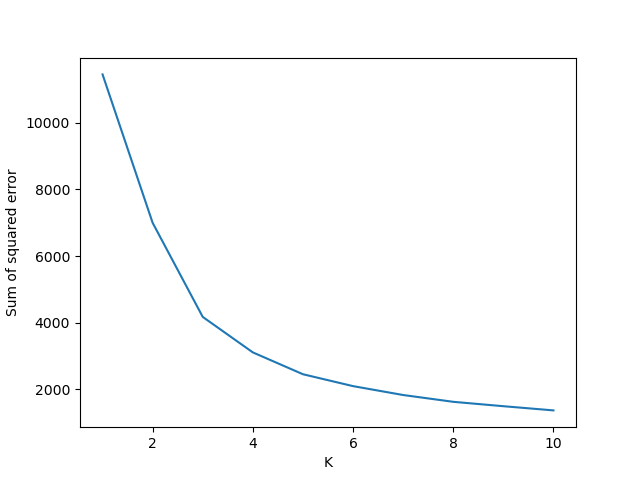

In [31]:
fig, ax = plt.subplots()
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)
plt.show()

In [32]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
y_predicted

array([2, 2, 0, ..., 1, 0, 0])

In [33]:
km.cluster_centers_

array([[-0.18159141, -0.18994013, -0.47922416],
       [-0.45152509, -0.54205644,  1.52708108],
       [ 1.8409755 ,  2.06812236, -0.69439667]])

In [34]:
rfm_scaled['Cluster']=y_predicted
rfm_scaled.head()

,Monetary,Frequency,Recency,Cluster
0,1.569442,0.404084,-0.924176,2
1,1.513385,1.573224,-0.904139,2
2,-0.165461,-0.131771,-0.914158,0
3,-0.618491,-0.777234,1.199669,1
4,-0.161974,-0.290092,-0.232924,0


In [35]:
rfm1=rfm_scaled[rfm_scaled['Cluster']==0]
rfm2=rfm_scaled[rfm_scaled['Cluster']==1]
rfm3=rfm_scaled[rfm_scaled['Cluster']==2]

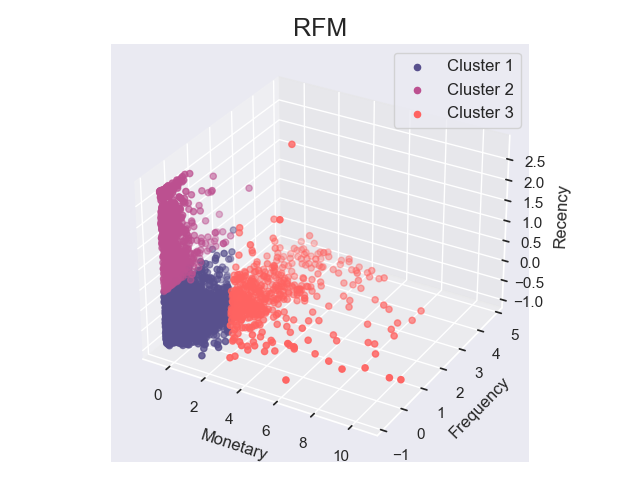

In [36]:
%matplotlib widget
sns.set(style = "darkgrid")
kplot = plt.axes(projection = '3d')
kplot.scatter3D(rfm1.Monetary, rfm1.Frequency, rfm1.Recency, c='#58508d', label = 'Cluster 1')
kplot.scatter3D(rfm2.Monetary, rfm2.Frequency, rfm2.Recency, c='#bc5090', label = 'Cluster 2')
kplot.scatter3D(rfm3.Monetary, rfm3.Frequency, rfm3.Recency, c='#ff6361', label = 'Cluster 3')
kplot.set_xlabel("Monetary",fontsize=12)
kplot.set_ylabel("Frequency",fontsize=12)
kplot.set_zlabel("Recency",fontsize=12)
plt.title("RFM",fontsize=18)
plt.legend(bbox_to_anchor=(1.0,1.0),prop={'size': 12})
plt.tight_layout()
plt.show()

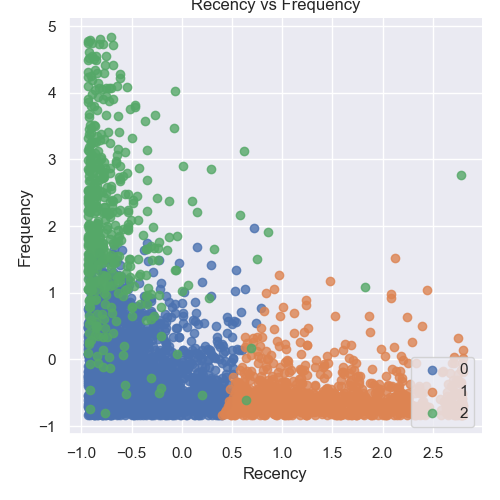

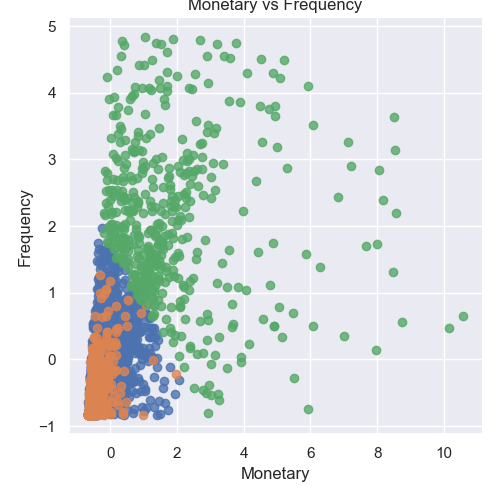

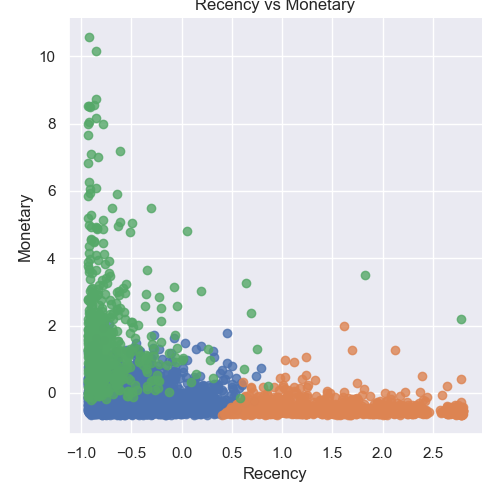

In [57]:
sns.lmplot(x="Monetary", y="Frequency", data=rfm_scaled, fit_reg=False, hue='Cluster', legend=False).set(title='Monetary vs Frequency')
sns.lmplot(x="Recency", y="Monetary", data=rfm_scaled, fit_reg=False, hue='Cluster', legend=False).set(title='Recency vs Monetary')
sns.lmplot(x="Recency", y="Frequency", data=rfm_scaled, fit_reg=False, hue='Cluster', legend=False).set(title='Recency vs Frequency')
plt.legend(loc='lower right')
plt.show()
